# Day 1: Capital Asset Pricing Model (CAPM)

## Learning Objectives
- Understand the theoretical foundation of CAPM
- Calculate beta using regression analysis
- Interpret CAPM results for portfolio management
- Visualize the Security Market Line (SML)

## Key Formula
$$E[R_i] = R_f + \beta_i(E[R_m] - R_f)$$

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from pathlib import Path

# Configuration
DATA_DIR = Path('../datasets/raw_data')
TRADING_DAYS = 252
RISK_FREE_RATE = 0.05  # 5% annual

# Load data
df = pd.read_csv(DATA_DIR / 'combined_adjusted_close.csv', index_col='Date', parse_dates=True)
prices = df.ffill().dropna()
returns = prices.pct_change().dropna()

print("="*60)
print("CAPM ANALYSIS - DAY 1")
print("="*60)
print(f"Data: {len(returns)} days, {len(returns.columns)} assets")

CAPM ANALYSIS - DAY 1
Data: 1834 days, 63 assets


## 1. Calculate Beta Using Regression

In [2]:
# Use SPY as market proxy
market_returns = returns['SPY']
daily_rf = RISK_FREE_RATE / TRADING_DAYS

def calculate_beta(stock_returns, market_returns):
    """Calculate beta using covariance method."""
    covariance = np.cov(stock_returns, market_returns)[0, 1]
    market_variance = np.var(market_returns)
    return covariance / market_variance

def calculate_beta_regression(stock_returns, market_returns):
    """Calculate beta using OLS regression."""
    excess_stock = stock_returns - daily_rf
    excess_market = market_returns - daily_rf
    
    X = sm.add_constant(excess_market)
    model = sm.OLS(excess_stock, X).fit()
    
    return model.params.iloc[1], model.params.iloc[0], model.rsquared

# Calculate betas for select stocks
test_stocks = ['AAPL', 'MSFT', 'JPM', 'XOM', 'JNJ', 'GLD']

print("\n" + "="*60)
print("BETA CALCULATIONS")
print("="*60)
print(f"{'Stock':<8} {'Beta (Cov)':<12} {'Beta (OLS)':<12} {'Alpha':<12} {'R²':<8}")
print("-"*60)

beta_results = []
for stock in test_stocks:
    if stock in returns.columns:
        beta_cov = calculate_beta(returns[stock], market_returns)
        beta_ols, alpha, r2 = calculate_beta_regression(returns[stock], market_returns)
        
        beta_results.append({
            'stock': stock,
            'beta': beta_ols,
            'alpha': alpha * TRADING_DAYS,  # Annualized
            'r2': r2
        })
        
        print(f"{stock:<8} {beta_cov:<12.4f} {beta_ols:<12.4f} {alpha*TRADING_DAYS:<12.4%} {r2:<8.4f}")

beta_df = pd.DataFrame(beta_results)


BETA CALCULATIONS
Stock    Beta (Cov)   Beta (OLS)   Alpha        R²      
------------------------------------------------------------
AAPL     1.2220       1.2213       10.9514%     0.6038  
MSFT     1.1533       1.1526       6.4053%      0.6443  
JPM      1.0734       1.0728       4.5977%      0.5014  
XOM      0.8060       0.8055       2.7956%      0.2599  
JNJ      0.4276       0.4274       1.6073%      0.1921  
GLD      0.0849       0.0849       12.2666%     0.0113  


## 2. Security Market Line (SML)

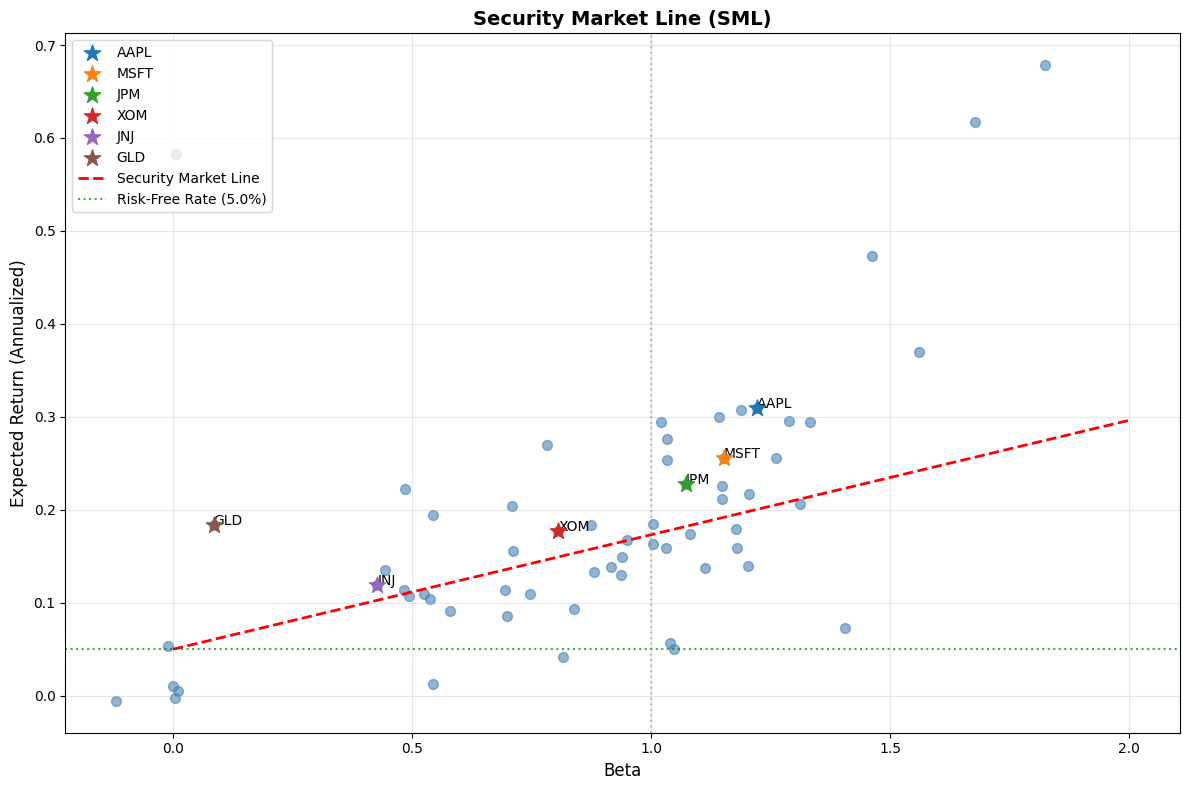


💡 Stocks ABOVE the SML have positive alpha (undervalued)
   Stocks BELOW the SML have negative alpha (overvalued)


In [3]:
# Calculate expected returns and betas for all stocks
all_betas = []
all_returns = []
all_stocks = []

for stock in returns.columns:
    if stock != 'SPY':
        try:
            beta, alpha, r2 = calculate_beta_regression(returns[stock], market_returns)
            annual_return = returns[stock].mean() * TRADING_DAYS
            
            all_betas.append(beta)
            all_returns.append(annual_return)
            all_stocks.append(stock)
        except:
            pass

# Plot SML
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot of all stocks
ax.scatter(all_betas, all_returns, alpha=0.6, s=50, c='steelblue')

# Highlight test stocks
for stock in test_stocks:
    if stock in all_stocks:
        idx = all_stocks.index(stock)
        ax.scatter(all_betas[idx], all_returns[idx], s=150, marker='*', 
                   label=stock, zorder=5)
        ax.annotate(stock, (all_betas[idx], all_returns[idx]), fontsize=10)

# Security Market Line
market_return = market_returns.mean() * TRADING_DAYS
beta_range = np.linspace(0, 2, 100)
sml = RISK_FREE_RATE + beta_range * (market_return - RISK_FREE_RATE)
ax.plot(beta_range, sml, 'r--', linewidth=2, label='Security Market Line')

ax.axhline(RISK_FREE_RATE, color='green', linestyle=':', alpha=0.7, label=f'Risk-Free Rate ({RISK_FREE_RATE:.1%})')
ax.axvline(1, color='gray', linestyle=':', alpha=0.5)

ax.set_xlabel('Beta', fontsize=12)
ax.set_ylabel('Expected Return (Annualized)', fontsize=12)
ax.set_title('Security Market Line (SML)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Stocks ABOVE the SML have positive alpha (undervalued)")
print("   Stocks BELOW the SML have negative alpha (overvalued)")

## 3. CAPM Applications

In [4]:
print("="*60)
print("CAPM APPLICATIONS")
print("="*60)

# 1. Expected Return Calculation
print("\n📊 Expected Returns (CAPM):")
market_premium = market_return - RISK_FREE_RATE
print(f"   Market Risk Premium: {market_premium:.2%}")

for _, row in beta_df.iterrows():
    expected_return = RISK_FREE_RATE + row['beta'] * market_premium
    print(f"   {row['stock']}: E[R] = {RISK_FREE_RATE:.1%} + {row['beta']:.2f} × {market_premium:.2%} = {expected_return:.2%}")

# 2. Portfolio Beta
print("\n📊 Portfolio Beta Calculation:")
weights = np.array([0.3, 0.25, 0.2, 0.15, 0.1])  # Example weights
stock_betas = beta_df['beta'].values[:5]
portfolio_beta = np.dot(weights, stock_betas)
print(f"   Portfolio Beta: {portfolio_beta:.4f}")
print(f"   Portfolio Expected Return: {RISK_FREE_RATE + portfolio_beta * market_premium:.2%}")

# 3. Cost of Equity
print("\n📊 Cost of Equity (for company valuation):")
for _, row in beta_df.iterrows():
    cost_of_equity = RISK_FREE_RATE + row['beta'] * market_premium
    print(f"   {row['stock']}: {cost_of_equity:.2%}")

CAPM APPLICATIONS

📊 Expected Returns (CAPM):
   Market Risk Premium: 12.32%
   AAPL: E[R] = 5.0% + 1.22 × 12.32% = 20.04%
   MSFT: E[R] = 5.0% + 1.15 × 12.32% = 19.20%
   JPM: E[R] = 5.0% + 1.07 × 12.32% = 18.21%
   XOM: E[R] = 5.0% + 0.81 × 12.32% = 14.92%
   JNJ: E[R] = 5.0% + 0.43 × 12.32% = 10.26%
   GLD: E[R] = 5.0% + 0.08 × 12.32% = 6.05%

📊 Portfolio Beta Calculation:
   Portfolio Beta: 1.0327
   Portfolio Expected Return: 17.72%

📊 Cost of Equity (for company valuation):
   AAPL: 20.04%
   MSFT: 19.20%
   JPM: 18.21%
   XOM: 14.92%
   JNJ: 10.26%
   GLD: 6.05%


## 4. Rolling Beta Analysis

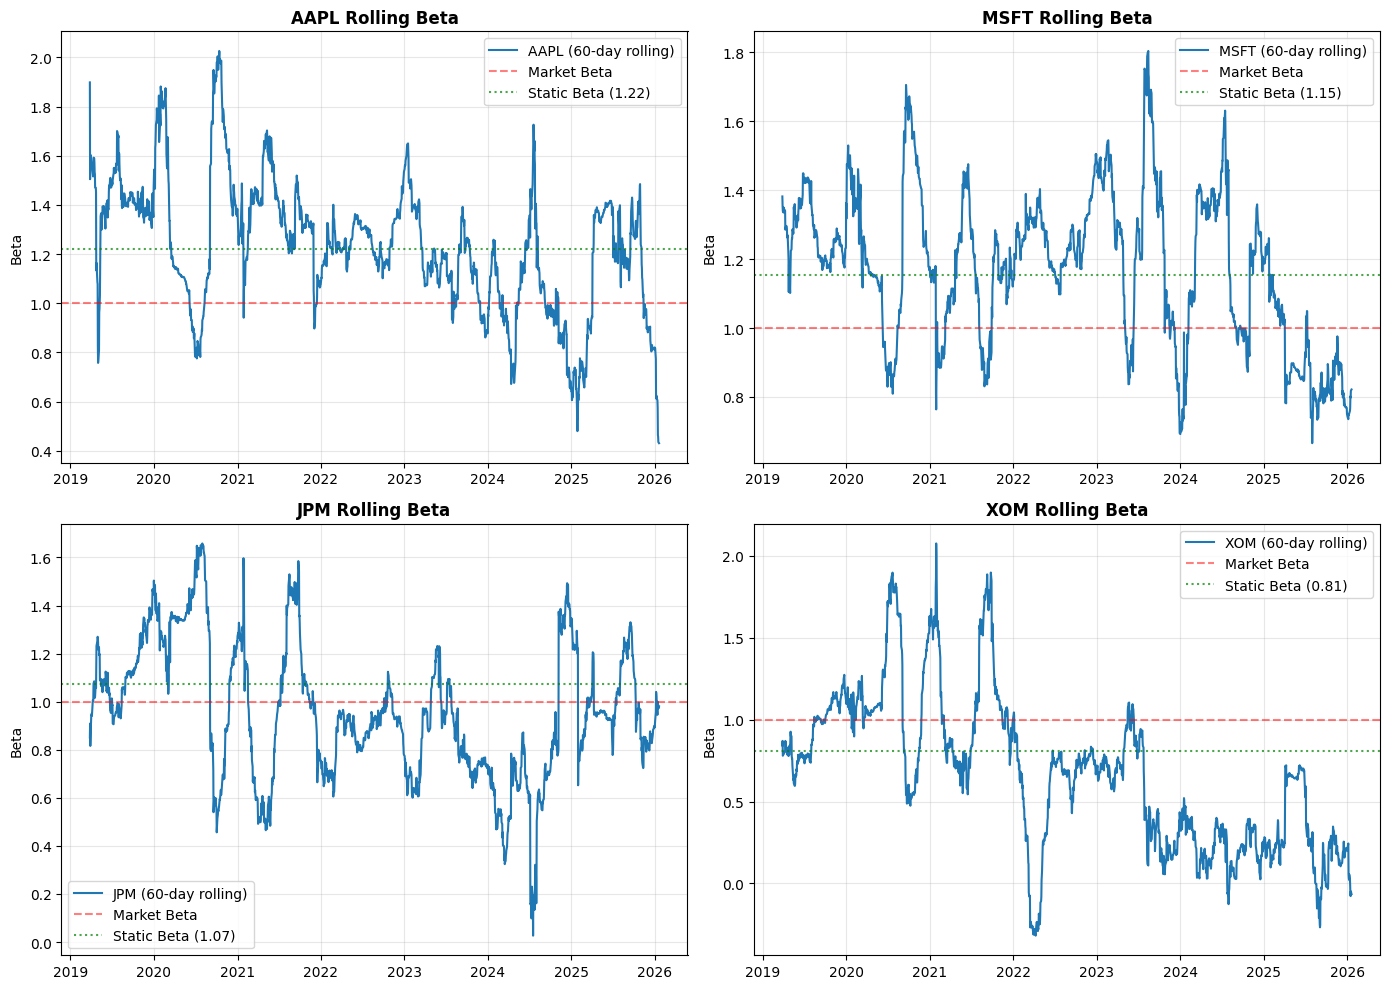


💡 Key Insight: Beta is NOT constant over time!
   - Betas tend to increase during market stress
   - Rolling beta captures changing risk relationships


In [5]:
def rolling_beta(stock_returns, market_returns, window=60):
    """Calculate rolling beta."""
    rolling_cov = stock_returns.rolling(window).cov(market_returns)
    rolling_var = market_returns.rolling(window).var()
    return rolling_cov / rolling_var

# Calculate rolling betas
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, stock in enumerate(['AAPL', 'MSFT', 'JPM', 'XOM']):
    if stock in returns.columns:
        rb = rolling_beta(returns[stock], market_returns, window=60)
        
        axes[i].plot(rb.index, rb.values, label=f'{stock} (60-day rolling)')
        axes[i].axhline(1, color='red', linestyle='--', alpha=0.5, label='Market Beta')
        
        # Add static beta
        static_beta = calculate_beta(returns[stock], market_returns)
        axes[i].axhline(static_beta, color='green', linestyle=':', alpha=0.7, 
                       label=f'Static Beta ({static_beta:.2f})')
        
        axes[i].set_title(f'{stock} Rolling Beta', fontweight='bold')
        axes[i].set_ylabel('Beta')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Key Insight: Beta is NOT constant over time!")
print("   - Betas tend to increase during market stress")
print("   - Rolling beta captures changing risk relationships")

## 5. CAPM Limitations and Testing

In [6]:
print("="*60)
print("CAPM TESTING & LIMITATIONS")
print("="*60)

# Test: Is alpha significantly different from zero?
print("\n📊 Alpha Significance Tests:")
print(f"{'Stock':<8} {'Alpha':<12} {'t-stat':<10} {'p-value':<10} {'Significant?'}")
print("-"*60)

for stock in test_stocks:
    if stock in returns.columns:
        excess_stock = returns[stock] - daily_rf
        excess_market = market_returns - daily_rf
        
        X = sm.add_constant(excess_market)
        model = sm.OLS(excess_stock, X).fit()
        
        alpha = model.params.iloc[0] * TRADING_DAYS
        t_stat = model.tvalues.iloc[0]
        p_value = model.pvalues.iloc[0]
        significant = "Yes" if p_value < 0.05 else "No"
        
        print(f"{stock:<8} {alpha:<12.4%} {t_stat:<10.4f} {p_value:<10.4f} {significant}")

print("\n⚠️ CAPM Limitations:")
print("   1. Single-factor model may be insufficient")
print("   2. Beta is time-varying, not constant")
print("   3. Assumes investors only care about mean and variance")
print("   4. Market portfolio is unobservable (Roll's critique)")
print("   5. Anomalies: Size, value, momentum effects")

CAPM TESTING & LIMITATIONS

📊 Alpha Significance Tests:
Stock    Alpha        t-stat     p-value    Significant?
------------------------------------------------------------
AAPL     10.9514%     1.5393     0.1239     No
MSFT     6.4053%      1.0400     0.2985     No
JPM      4.5977%      0.5976     0.5502     No
XOM      2.7956%      0.2860     0.7749     No
JNJ      1.6073%      0.2550     0.7987     No
GLD      12.2666%     2.1453     0.0321     Yes

⚠️ CAPM Limitations:
   1. Single-factor model may be insufficient
   2. Beta is time-varying, not constant
   3. Assumes investors only care about mean and variance
   4. Market portfolio is unobservable (Roll's critique)
   5. Anomalies: Size, value, momentum effects


## Key Takeaways

1. **CAPM provides expected return** based on systematic risk (beta)
2. **Beta measures sensitivity** to market movements
3. **Alpha represents excess return** not explained by market exposure
4. **SML shows fair pricing** - above = undervalued, below = overvalued
5. **Beta varies over time** - use rolling analysis for dynamic risk

---
*Next: Day 2 - Fama-French 3-Factor Model*